# Initialize


In [1]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')
from AE.models import AE_0, ProgressiveAE
from AE.datasets import MNISTDigit2Dataset

from AE.depth_utils import get_KL_with_HFM_with_optimal_g, get_bottleneck_neurons_frequencies
from AE.plotter_functions import visualize_bottleneck_neurons, plot_KLs_vs_hidden_layers, datasets_dicts_comparison

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Utilizzo Apple Silicon GPU (MPS)")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Utilizzo NVIDIA GPU (CUDA)")
# else:
#     device = torch.device("cpu")
#     print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)




# Datasets


In [2]:

batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")



#-------------------------------------------------------------------


datasets = ["MNIST", "EMNIST", "2MNIST"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST
}


Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True


In [ ]:


## FashionMNIST

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



# Analysis

## 6 features


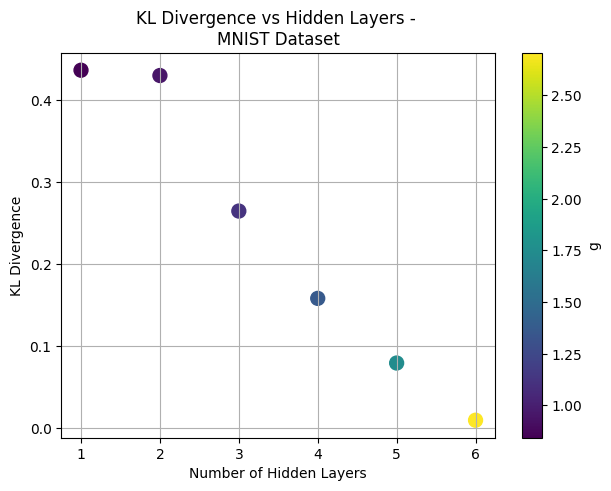

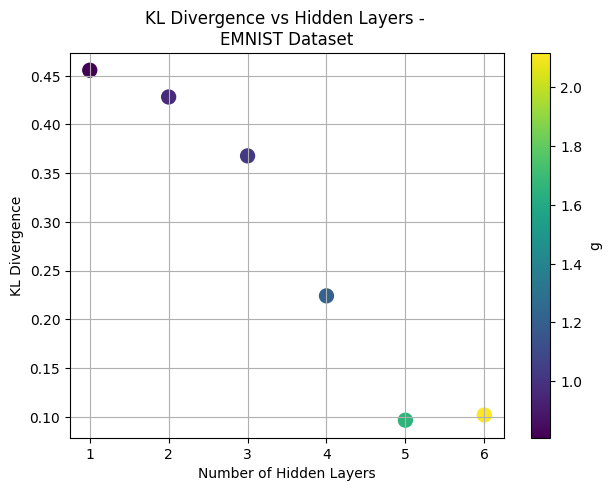

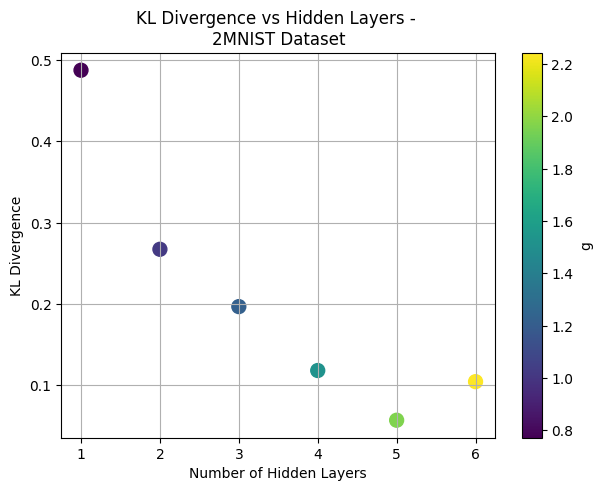

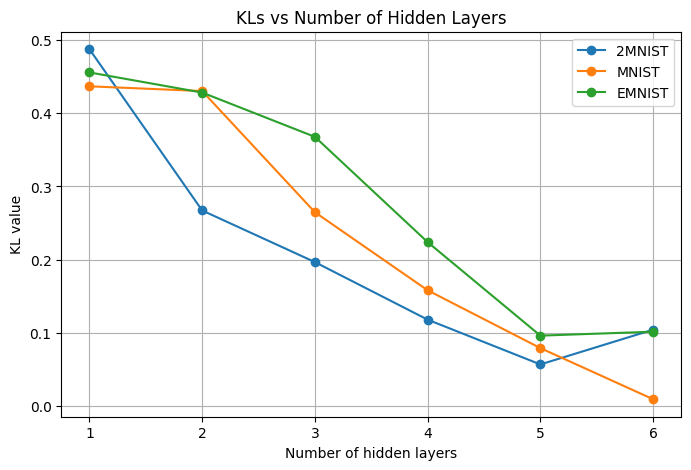

In [5]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 6
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

## 8 features

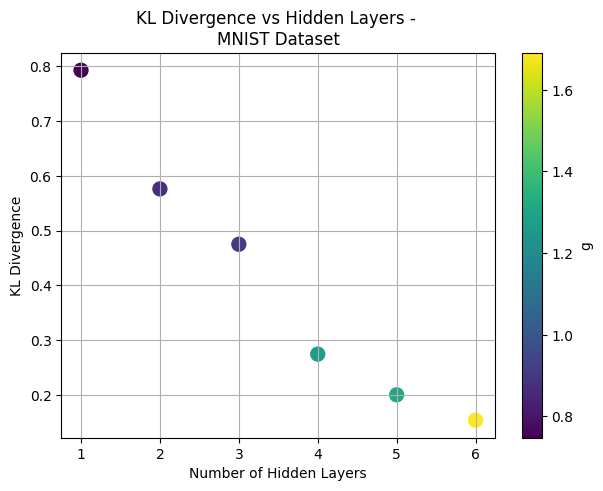

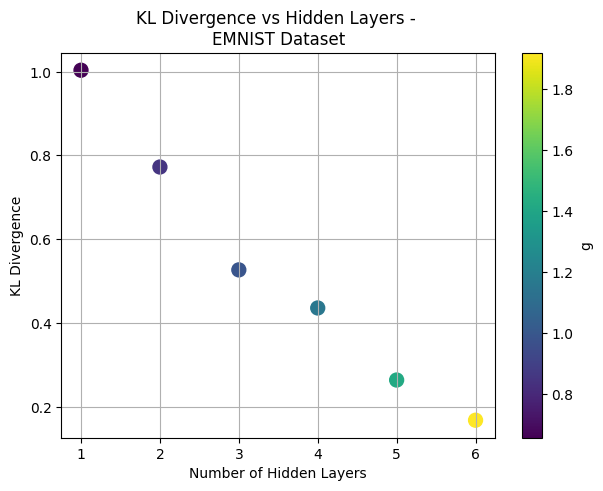

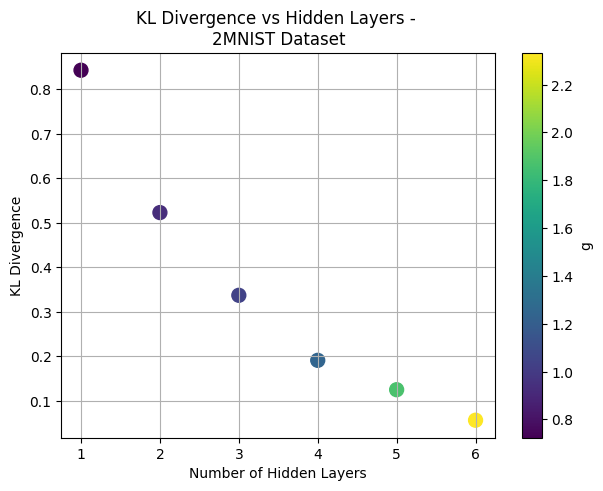

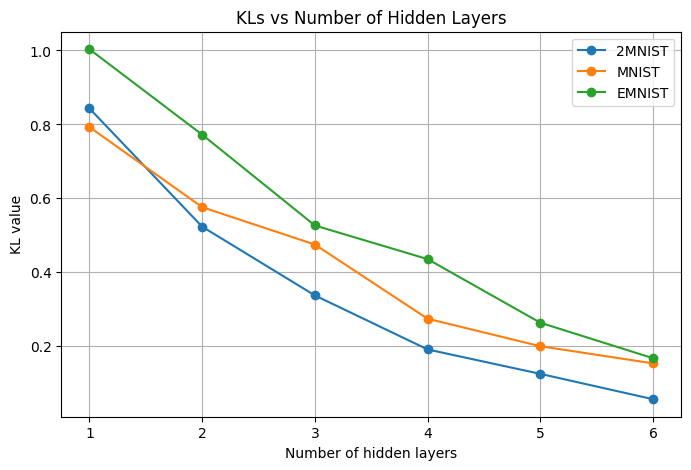

In [10]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

## 10 features


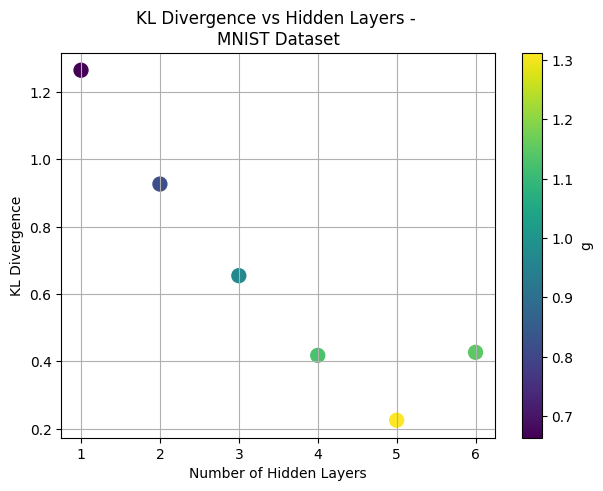

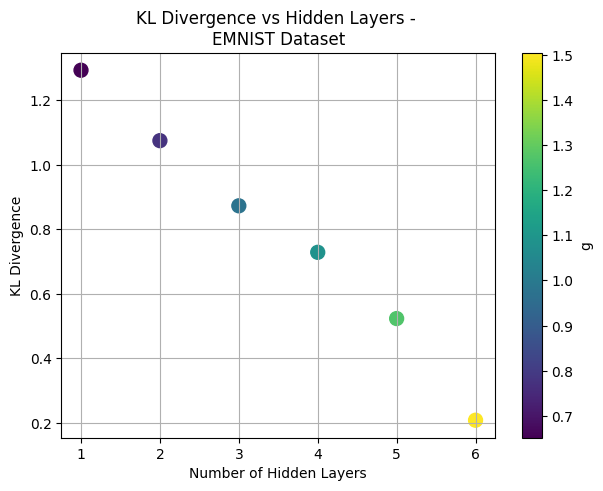

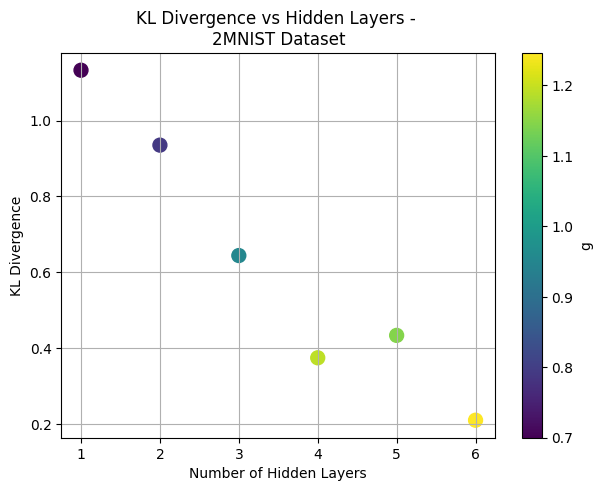

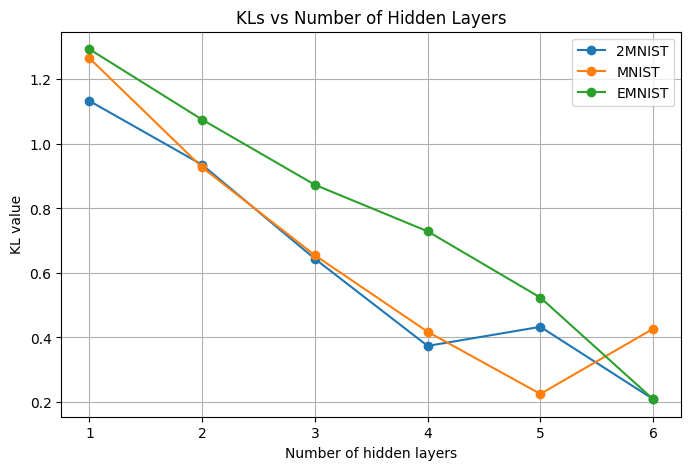

In [14]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 10
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

# Visualize 3hl features

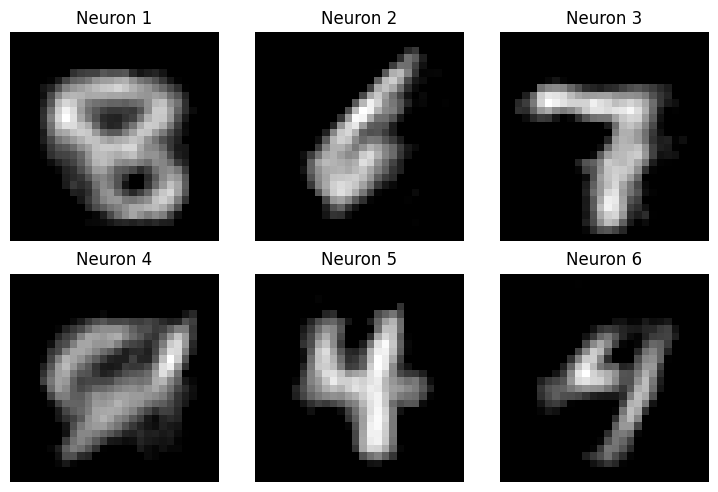

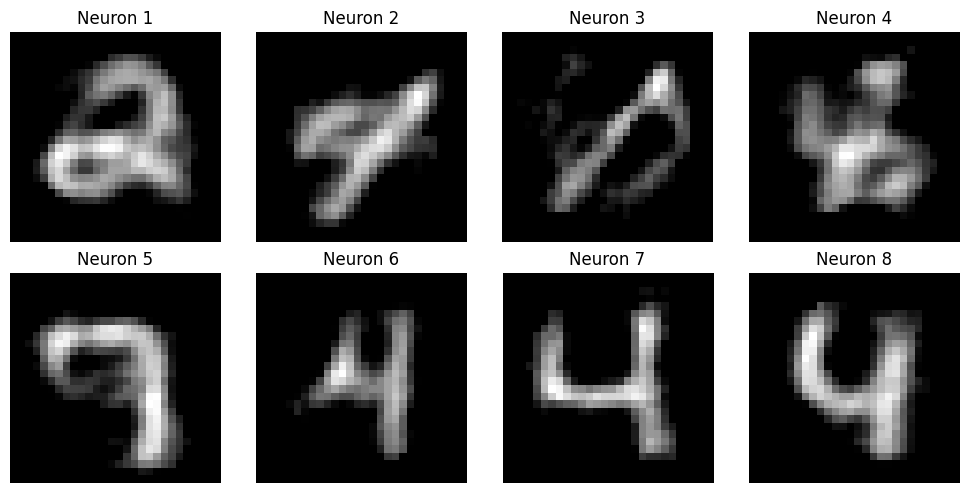

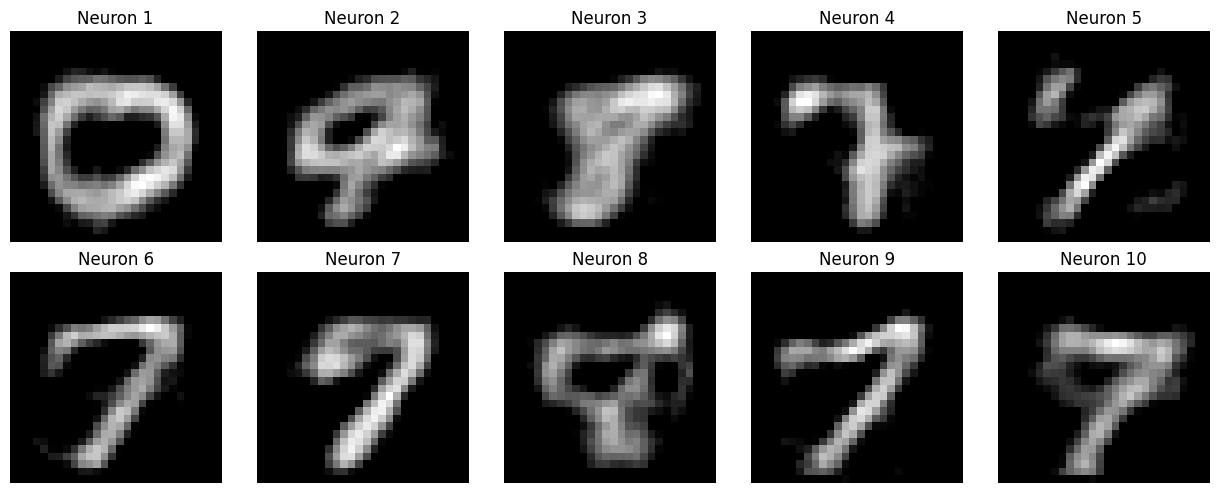

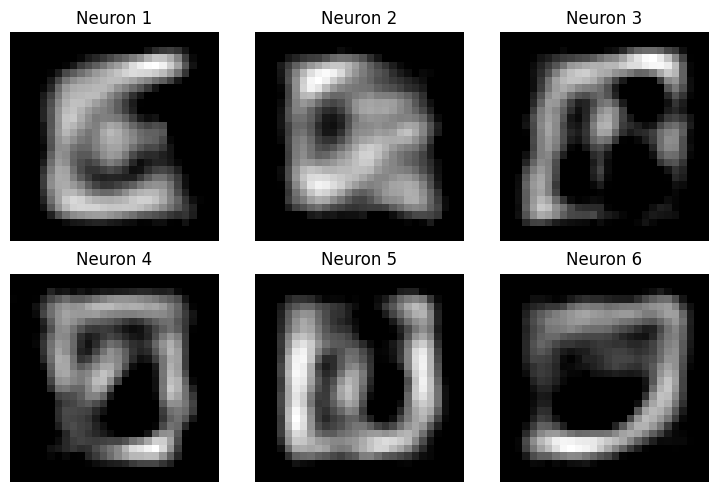

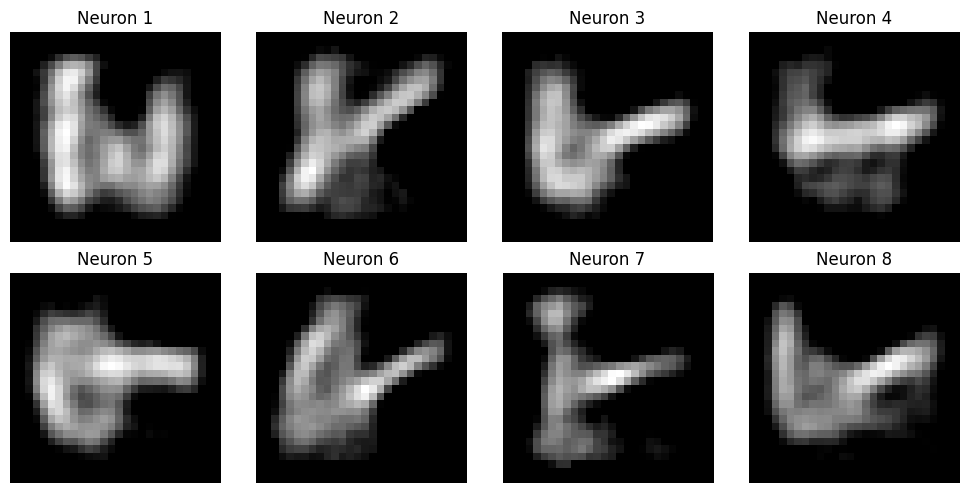

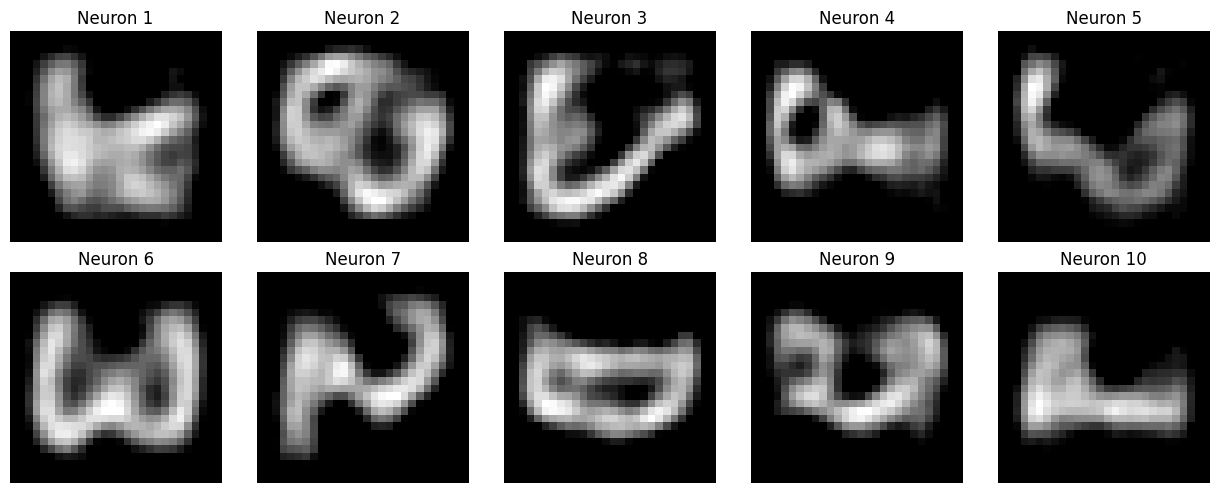

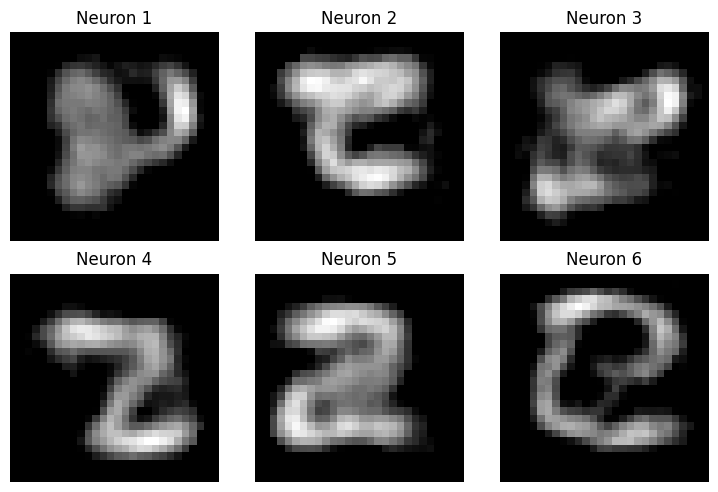

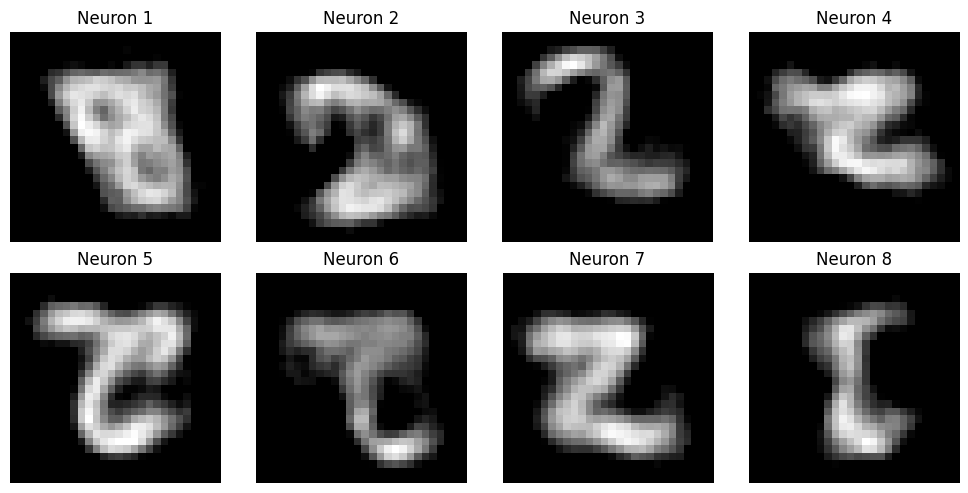

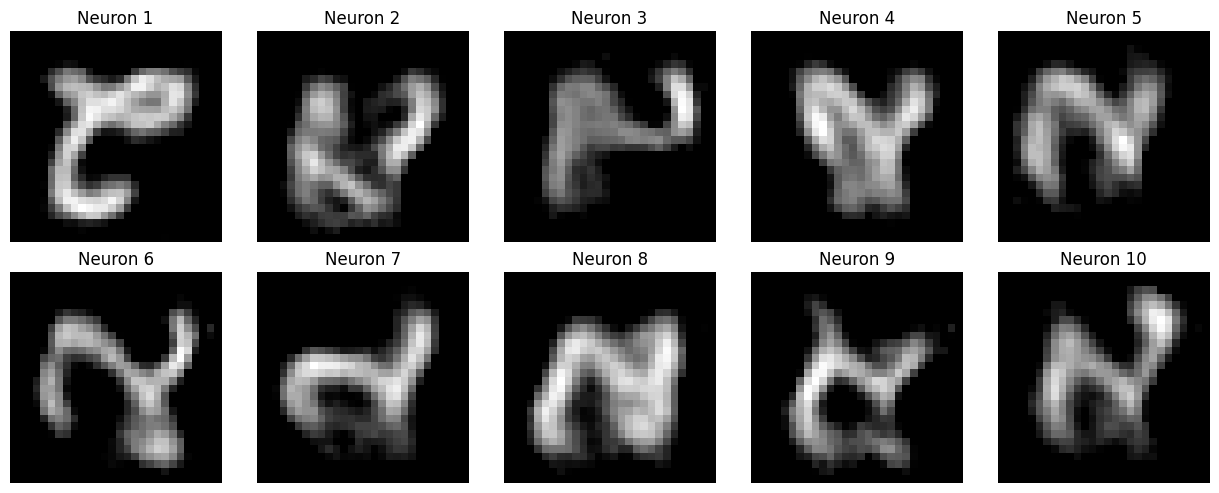

In [27]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../Images/{latent_dim}features/progressive train/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

# Bottleneck neurons activation frequencies

In [5]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = get_bottleneck_neurons_frequencies(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')



# Bottleneck weights

In [26]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        for thresh_for_bin in (0.3, 0.5, 0.8):
            with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/weights_mean_abs_value.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')

In [ ]:
# Weights mean

with torch.no_grad():
    for latent_dim in (6,8,10):
        for thresh_for_bin in (0.3, 0.5, 0.8):
            with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/weights_mean.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')


In [ ]:
"1 hl"
"    "